# Machine learning with tensorflow

TensorFlow is an end-to-end open source platform for machine learning. 

It has been released by Google and works also in Javascripts, IoT, mobile etc. 

SensorFlow’s high-level APIs are based on the Keras API standard for defining and training neural networks (same as Theano).

It also allow to use a notebook based environment (colab) to test models and prototypes

https://www.tensorflow.org/

This example is based on tutorial @
https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub


Modules needed:

pyyaml  # Required to save models in YAML format

tensorflow
tensorflow_hub
(install in anaconda with conda install -c conda-forge tensorflow-hub )

seaborn # data visualization library

### NOTE: tensorflow work with python 3.7 since feb 2019


In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

# from sklearn.preprocessing import MultiLabelBinarizer

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

W0403 15:10:22.375999 14432 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## importing patent data

Now we put in a dataframe a sample of patents from EPO with first IPC4 among:

A61B	DIAGNOSIS; SURGERY; IDENTIFICATION

A61K    PREPARATIONS FOR MEDICAL, DENTAL, OR TOILET PURPOSES

C07D	HETEROCYCLIC COMPOUNDS ACYCLIC, CARBOCYCLIC

G01N	INVESTIGATING OR ANALYSING MATERIALS BY DETERMINING THEIR CHEMICAL OR PHYSICAL PROPERTIES 

G06F	ELECTRIC DIGITAL DATA PROCESSING 

H01L 	SEMICONDUCTOR DEVICES

H04L	TRANSMISSION OF DIGITAL INFORMATION

H04N	PICTORIAL COMMUNICATION, e.g. TELEVISION

We also run some checks on distribution, nulls etc


In [2]:
data=pd.read_csv("patentdata_ipc4_5000.csv")

data.groupby('IPC4')['APPLN_ABSTRACT'].count() # check distribution of ipc4 in sample


IPC4
A61B    567
A61K    674
C07D    291
G01N    442
G06F    932
H01L    645
H04L    916
H04N    533
Name: APPLN_ABSTRACT, dtype: int64

In [3]:
# we run a check for empty values

data['APPLN_ABSTRACT'].isna().sum()

0

### data set up

We replace here IPC4 with a numeric tag via a dictionary;
we also set up description and clusters that will be the objects for our ML

In [4]:
data['cluster']=data['IPC4']

d1 = { 'A61B' : 0,
       'A61K' : 1,
       'C07D' : 2, 
       'G01N' : 3, 
       'G06F' : 4,
       'H01L' : 5,  
       'H04L' : 6,
       'H04N' : 7}

data.replace({'cluster': d1}, inplace=True)
data[['cluster']] = data[['cluster']].astype(int)


At this point we can split our data into training and testing sets 
using an 80% / 20% train / test split;

we also drop unnecessary columns


In [5]:
train_size = int(len(data) * .8)

train_df = data.loc[1:train_size, ['APPLN_ABSTRACT','cluster']]
test_df = data.loc[train_size:, ['APPLN_ABSTRACT','cluster']]


# shows size of 2 dfs
print(len(test_df) , len(train_df))



1000 4000


### Input functions

Estimator framework provides input functions that wrap Pandas dataframes.

#### tf.estimator 

is a high-level TensorFlow API that greatly simplifies machine learning programming. Estimators encapsulate the following actions:

training
evaluation
prediction
export for serving


#### tf.estimator.inputs.pandas_input_fn()

Args:
x: pandas DataFrame object.
y: pandas Series object or DataFrame. None if absent.
batch_size: int, size of batches to return.
num_epochs: int, number of epochs to iterate over data. If not None, read attempts that would exceed this value will raise OutOfRangeError.
shuffle: bool, whether to read the records in random order.


In [6]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["cluster"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["cluster"], shuffle=False)

# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["cluster"], shuffle=False)

## Embedding layers

Word embeddings provide a dense representation of words and their relative meanings.

They are an improvement over sparse representations used in simpler bag of word model representations.

Word embeddings can be learned from text data and reused among projects. They can also be learned as part of fitting a neural network on text data.

Words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.

The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

And for example a dense vector (1, 2, 0, 0, 5, 0, 9, 0, 0) will be represented as {(0,1,4,6), (1, 2, 5, 9)}
(position, value)

Our model will only have one feature (the description) and it’ll be represented as an embedding column.

TF Hub simplifies this process by providing text embeddings that have already been trained on a variety of text data.

For English text, TF Hub provides a variety of embeddings trained on different kinds of text data:

##### Universal sentence encoder: for longer form text inputs

##### ELMo: deep embeddings trained on the 1B Word Benchmark

##### Neural Network Language Model embeddings: trained on Google News

##### Word2vec: trained on Wikipedia

full details @https://tfhub.dev/s?q=embedding%20

For italian language is available a multilanguage embedding
https://tfhub.dev/google/universal-sentence-encoder-xling-many/1

The pre-trained text embeddings you choose is a hyperparameter in your model, so it’s best to experiment with different ones and see which one yields the highest accuracy. 

We can use hub.text_embedding_column to create a feature column for this layer in one line of code, passing it the name of our layer (“APPLN_ABSTRACT”) and the URL of the TF Hub model we’ll be using:


In [7]:
# it takes some time
# nnlm-en-dim128 = Neural Network Language Model embeddings
# if you like you can try other embeddings
# https://tfhub.dev/google/universal-sentence-encoder/2
# https://tfhub.dev/google/Wiki-words-500-with-normalization/1


embedded_text_feature_column = hub.text_embedding_column(
    key="APPLN_ABSTRACT", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1",
    trainable=True)

print('Hub model loaded!')

Hub model loaded!


## Estimator

The Estimator object wraps a model which is specified by a model_fn, which, given inputs and a number of other parameters, returns the ops necessary to perform training, evaluation, or predictions.

In this case a prebuilt DNNClassifier (Deep Neural Network) will be used since we have a dicrete range of values.
If we had mapped our values on a continuous we could have used DNNRegressor.

#### tf.estimator.DNNClassifier(

hidden_units: aka the neurons or dimensional space:  List of hidden units per layer. All layers are fully connected. Ex. [64, 32] means first layer has 64 nodes and second one has 32.

feature_columns: An iterable containing all the feature columns used by the model. All items in the set should be instances of classes derived from FeatureColumn.

model_dir: Directory to save model parameters, graph and etc. This can also be used to load checkpoints from the directory into a estimator to continue training a previously saved model.

n_classes: number of label classes. Default is binary classification. It must be greater than 1. Note: Class labels are integers representing the class index (i.e. values from 0 to n_classes-1). For arbitrary label values (e.g. string labels), convert to class indices first.

weight_column_name: A string defining feature column name representing weights. It is used to down weight or boost examples during training. It will be multiplied by the loss of the example.

optimizer: An instance of tf.Optimizer used to train the model. If None, will use an Adagrad optimizer.
(Learning rate : is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient. The lower the value, the slower we travel along the downward slope.




In [8]:
# run_config = tf.estimator.RunConfig(keep_checkpoint_max=1)

n_class = len(data["cluster"].unique())  # classes = distinct number of ipc4 in original dataset

estimator = tf.estimator.DNNClassifier(
    hidden_units=[250, 50],
    feature_columns=[embedded_text_feature_column],
    n_classes=n_class, 
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

In [9]:
estimator.train(input_fn=train_input_fn, steps=1000);

In [10]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.9980000257492065
Test set accuracy: 0.800000011920929


## Confusion matrix

Using seaborn we can visually check the confusion matrix to understand the distribution of misclassifications.

Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).


In [11]:
# we rescue d1 dictionary for labels of graph

LABELS = []
for d in d1:
    LABELS.append(d)

LABELS.sort()
print (LABELS)   


['A61B', 'A61K', 'C07D', 'G01N', 'G06F', 'H01L', 'H04L', 'H04N']


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]


# Create a confusion matrix on training data.

with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["cluster"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True , xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");



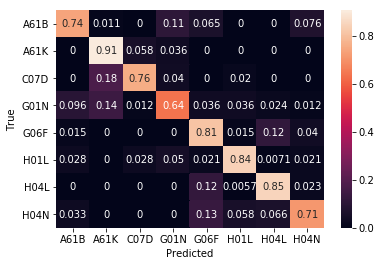

In [13]:
# Create a confusion matrix on test data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(test_df["cluster"], 
                           get_predictions(estimator, predict_test_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

## Exporting the results


This last step shows and exports forecasts:

add a column to test df with prediction

export to csv predicted results


In [14]:
# in dataframe we add a column with preditions

test_df["Predictions"] = get_predictions(estimator, predict_test_input_fn)


In [15]:

# step 1 invert my dictionary
inv_d1 = dict((d1[k], k) for k in d1)


# step 2 replace in predictions cluster index with label

test_df_export=test_df.copy()

test_df_export.replace({'cluster': inv_d1}, inplace=True)

test_df_export.replace({'Predictions': inv_d1}, inplace=True)

test_df_export[test_df_export.cluster != test_df_export.Predictions].head()



,APPLN_ABSTRACT,cluster,Predictions
4007,In a display device having a dual view display...,G06F,H04N
4036,This invention relates to the use of a nanostr...,G01N,C07D
4041,"Peptide sequences as agents for curing, preven...",A61K,G01N
4048,A subject (W) which is to be treated and on wh...,H01L,G01N
4049,A subject (W) which is to be treated and on wh...,H01L,G01N


In [16]:
# last step export csv

test_df_export.to_csv('test_check.csv')


## Tagging another set of data

Last step is to apply out ML algorithm is to run it on another dataset;

For this purpose an extract of WOS abstracts in field of computer science will be used.

We need only to name according the columns and get predictions



In [17]:

data2=pd.read_csv("wos_abstracts_cs_1000.csv")

predict_df = data2.loc[:, ['abstract']]
predict_df.columns = ['APPLN_ABSTRACT']

predict_df["cluster"]=4  # G06F expectation 

predict_df.head()

,APPLN_ABSTRACT,cluster
0,\r\n<p>We describe BARNACLE: a co-operative in...,4
1,\r\n<p>We describe BARNACLE: a co-operative in...,4
2,\r\n<p>Cyclostationary processes are an import...,4
3,\r\n<p>Cyclostationary processes are an import...,4
4,\r\n<p>A mixed approach to large strain elasto...,4


In [28]:
predict_predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    predict_df, predict_df["cluster"], shuffle=False)

# estimator.train(input_fn=predict_predict_input_fn, steps=1000);

predict_df["Predictions"] = get_predictions(estimator, predict_predict_input_fn)

# put back IPC4

predict_df.replace({'cluster': inv_d1}, inplace=True)
predict_df.replace({'Predictions': inv_d1}, inplace=True)

predict_df.head()


,APPLN_ABSTRACT,cluster,Predictions
0,\r\n<p>We describe BARNACLE: a co-operative in...,G06F,G06F
1,\r\n<p>We describe BARNACLE: a co-operative in...,G06F,G06F
2,\r\n<p>Cyclostationary processes are an import...,G06F,G01N
3,\r\n<p>Cyclostationary processes are an import...,G06F,G01N
4,\r\n<p>A mixed approach to large strain elasto...,G06F,H01L


In [29]:
# count of records by prediction

predict_df.groupby("Predictions")['APPLN_ABSTRACT'].count()


Predictions
A61B     20
A61K     11
C07D      4
G01N    130
G06F    691
H01L     19
H04L     86
H04N     39
Name: APPLN_ABSTRACT, dtype: int64

### Parameter tuning: 

we can improve the accuracy by tuning the meta-parameters like the learning rate or the number of steps, especially if we use a different module. A validation set is very important if we want to get any reasonable results, because it is very easy to set-up a model that learns to predict the training data without generalizing well to the test set.